In [ ]:
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch.fft
import torch.utils.data
import torchvision.transforms as T
import tqdm

from src.data import transforms
from src.data.dataset import BGREMDataset
from src.model.modules import NoOp
from src.model.unet import HalfUNetDiscriminator, UNet

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
masker = transforms.DiffIntensityMasker(150)
data_paths = list(pathlib.Path("data/processed/").glob("**/*.npy"))
len(data_paths)

11731

In [ ]:
detected = {}
for path in tqdm.tqdm(data_paths):
    img = np.load(path)
    if img.shape[2] == 4:
        img = np.concatenate([img, np.ones_like(img[:, :, :1]) * 255], axis=-1)
    bgr = img[:, :, :3]
    event = img[:, :, 3:4]
    event_mask = img[:, :, 4]
    mask = masker(0, bgr, event_mask, event)
    total_dets = (mask > 0).sum()
    if total_dets > 0:
        detected[path] = total_dets

100%|██████████| 11731/11731 [01:02<00:00, 188.61it/s]


In [ ]:
most = sorted(detected.items(), key=lambda x: x[1], reverse=True)
len(most)

3598

In [ ]:
target_dir = pathlib.Path("data/excluded/")
for path, _ in most[:1000]:
    if not path.exists():
        continue
    parent_dir = path.parent
    target_path = target_dir / parent_dir.name / path.name
    target_path.parent.mkdir(parents=True, exist_ok=True)
    path.rename(target_path)

In [ ]:
# del first 800?

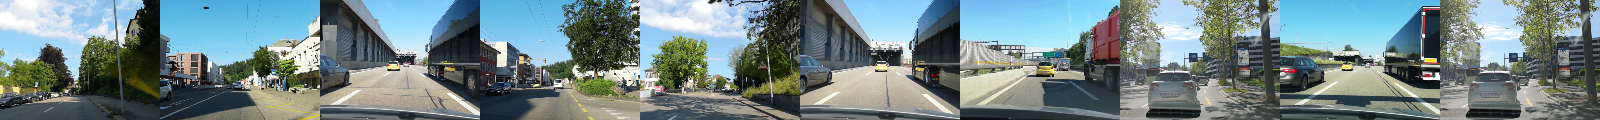

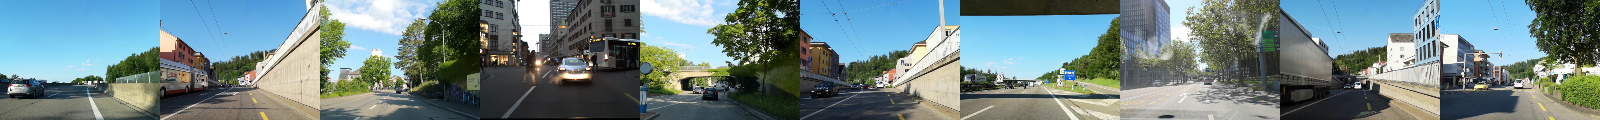

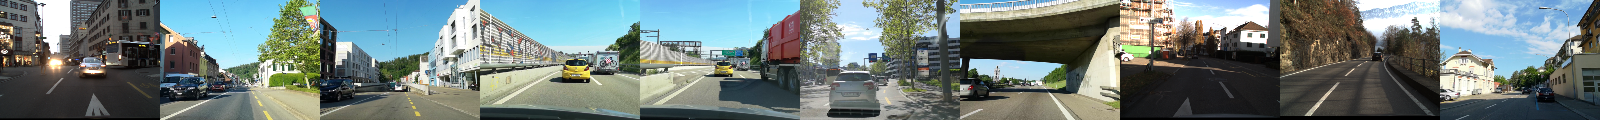

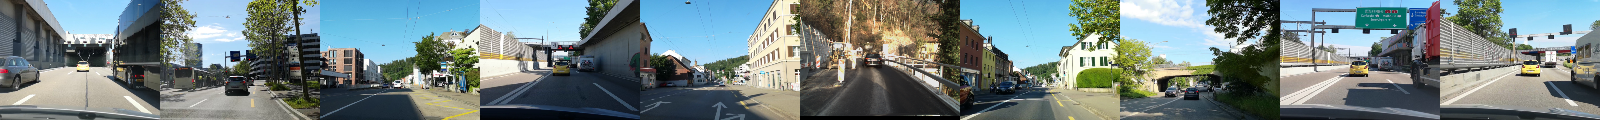

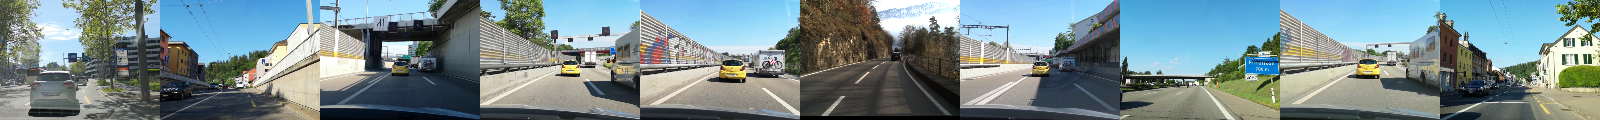

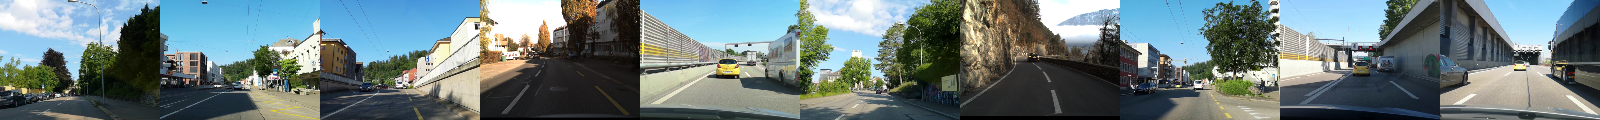

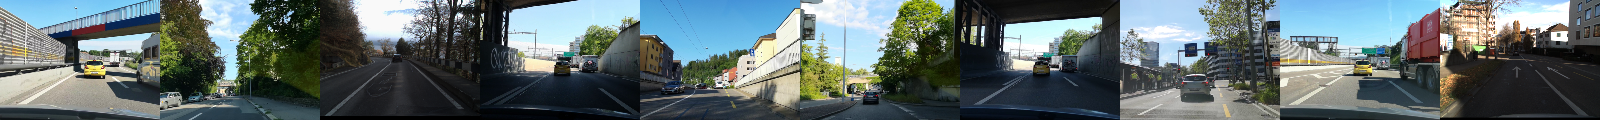

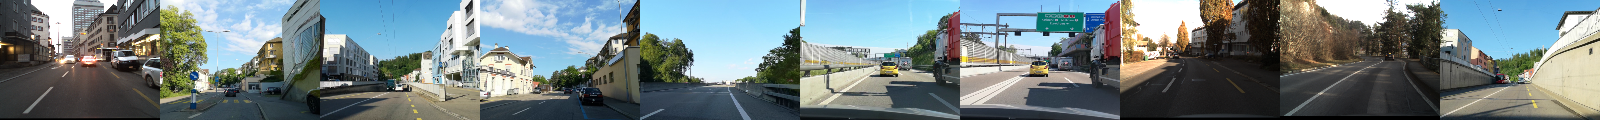

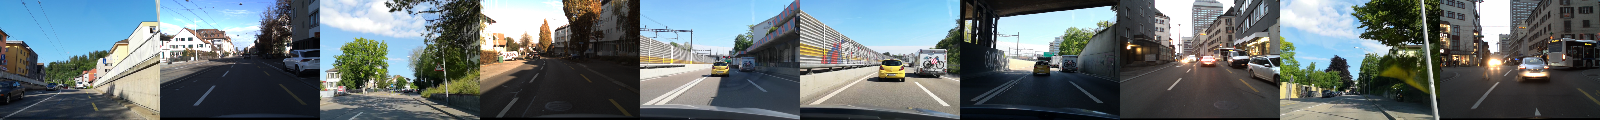

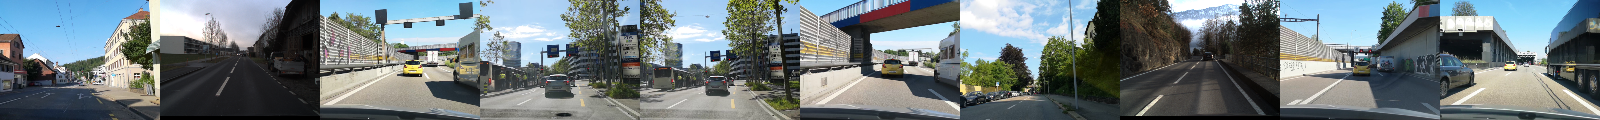

In [14]:
start = 1500
for i in range(start, start + 100, 10):
    imgs = []
    for j in range(10):
        idx = i + j
        img = np.load(most[idx][0])[:, :, :3]
        img_down = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)
        imgs.append(img_down)
    combined = np.concatenate(imgs, axis=1)
    showarray(combined)

In [ ]:
most_by_dataset = {}
for path, count in most:
    dataset = path.parent.name
    if dataset not in most_by_dataset:
        most_by_dataset[dataset] = []
    most_by_dataset[dataset].append((path, count))

In [ ]:
for dataset, paths in most_by_dataset.items():
    print(f"{dataset}: {len(paths)}")

uzh: 2710
dsec: 888
